# seq2one 단방향 전이학습 LSTM 예제

- 전이학습에 대한 예제
- 사용할 모델은 lstm으로 아래와 같이 모든 모델을 통일하도록 함
    - seq2one 구조의 데이터
    - 단방향
    - 2층구조, 각 층의 unit은 64개

---

# import 

In [6]:
from datasetsforecast.m4 import M4, M4Evaluation
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time

from keras.layers import LSTM ,Dense 
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping

# source data

- 소스데이터는 m4데이터의 hourly data로 24주기의 계절성분을 지님
- 24주기의 타임스탭과 363436의 data size를 지닌다


In [12]:
df,*_= M4.load(directory='data',group = 'Hourly')

lst = list(set(df.loc[:,'unique_id']))

tt = [df[df.loc[:,'unique_id']==lst[i]].iloc[:,1:4].set_index(['ds']) 
      for i in range(len(lst))]

for l in range(len(tt)):
    for s in range(1, 25):
        tt[l]['shift_{}'.format(s)] = tt[l]['y'].shift(s)
        tt[l]['shift_{}'.format(s)] = tt[l]['y'].shift(s)
        
tt=[tt[i].dropna(axis=0) for i in range(len(tt))]

train = np.concatenate([np.array(tt[i].iloc[:,1:]) for i in range(len(tt))])
y = np.concatenate([np.array(tt[i].iloc[:,0]) for i in range(len(tt))]).reshape(-1,1)

from sklearn.preprocessing import MinMaxScaler
min_max_scaler1 = MinMaxScaler()

X_scale = min_max_scaler1.fit_transform(train)
y_scale = min_max_scaler1.fit_transform(y)

In [109]:
X_scale.shape, y_scale.shape

((363436, 24), (363436, 1))

---

# target data
- target data는 마지막으로부터 2400개의 정보만 쓰기로함
- target data의 크기가 커질수록 전이학습의 효력은 떨어질 것으로 예상되어짐
- 가지고 있는 data가 작을 수록 유의한 성능을 보여줄 수 있지 않을까

In [82]:
df = pd.read_csv('C:/Users/default.DESKTOP-2ISHQBS/Documents/R/time_ele/train.csv')

arr = df.iloc[:,9] # 전력소비량
date=  pd.to_datetime(df.iloc[:,2]) # 일시

df_= pd.DataFrame({'date':date,
              'ele': arr})

df_ = df_.set_index('date')

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

df_['mmele'] = min_max_scaler.fit_transform(df_.iloc[:].to_numpy().reshape(-1,1))

df_ = df_.drop(['ele'],axis=1)

for s in range(1, 25):
    df_['shift_{}'.format(s)] = df_['mmele'].shift(s)
    df_['shift_{}'.format(s)] = df_['mmele'].shift(s)

df_ = df_.dropna()

y = df_.iloc[:,[0]].values #scaled 

X = df_.iloc[:,1:]

from sklearn.model_selection import train_test_split

x_train,x_test, y_train , y_test = train_test_split(X.iloc[-2400:,:],y[-2400:],shuffle=False, test_size=0.1)

In [112]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2160, 24), (240, 24), (2160, 1), (240, 1))

- target data는 마지막으로부터 2400개의 정보만 쓰기로함
- target data의 크기가 커질수록 전이학습의 효력은 떨어질 것으로 예상되어짐
- 가지고 있는 data가 작을 수록 유의한 성능을 보여줄 수 있지 않을까

---

# non pretrained lstm model

- 비교군 모델
- 타겟 데이터를 직접적으로 피팅하고 예측

In [83]:
K.clear_session()
model0 = Sequential() # Sequeatial Model
model0.add(LSTM(64, return_sequences=True,input_shape=(24, 1)))# (timestep, feature)
model0.add(LSTM(64))
model0.add(Dense(1)) # output = 1
model0.compile(loss='mean_squared_error', optimizer='adam')

In [85]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
start_time0 = time.time()
model0.fit(x_train,y_train, epochs=100,
          batch_size=128, verbose=1, callbacks=[early_stop])
end_time0 = time.time()

Epoch 1/100
17/17 [==============================] - 3s 14ms/step - loss: 3.1825e-04
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 1.7635e-04
Epoch 3/100
17/17 [==============================] - 0s 14ms/step - loss: 1.5396e-04
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 1.3626e-04
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 1.1880e-04
Epoch 6/100
17/17 [==============================] - 0s 14ms/step - loss: 9.0592e-05
Epoch 7/100
17/17 [==============================] - 0s 14ms/step - loss: 5.7634e-05
Epoch 8/100
17/17 [==============================] - 0s 14ms/step - loss: 3.5648e-05
Epoch 9/100
17/17 [==============================] - 0s 14ms/step - loss: 2.6257e-05
Epoch 10/100
17/17 [==============================] - 0s 14ms/step - loss: 2.7105e-05
Epoch 10: early stopping


In [86]:
total_training_time0 = end_time0 - start_time0

print(f"총 학습에 걸린 시간: {total_training_time0} 초")

총 학습에 걸린 시간: 4.8234617710113525 초


---

# pretrained LSTM model
- 2개의 레이어를 전이학습에 사용
- 따라서 모든 시퀀스를 반환해야하기 때문에 return_sequences=True 사용
- output 레이어는 사용하지 않음

In [55]:
K.clear_session()
model1 = Sequential() # Sequeatial Model
model1.add(LSTM(64, return_sequences=True, input_shape=(24, 1))) # (timestep, feature)
model1.add(LSTM(64, return_sequences=True)) # 연결한 모델의 차원을 맞추기 위해 시퀀스 반환을 함
model1.add(Dense(1)) # output 사용 x
model1.compile(loss='mean_squared_error', optimizer='adam')

In [56]:
np.random.seed(1)
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model1.fit(X_scale, y_scale, epochs=100,
          batch_size=128, verbose=1, callbacks=[early_stop])

Epoch 1/100
2840/2840 [==============================] - 44s 15ms/step - loss: 1.5204e-04
Epoch 2/100
2840/2840 [==============================] - 42s 15ms/step - loss: 2.3503e-05
Epoch 3/100
2840/2840 [==============================] - 44s 15ms/step - loss: 1.0142e-05
Epoch 4/100
2840/2840 [==============================] - 44s 16ms/step - loss: 7.2908e-06
Epoch 5/100
2840/2840 [==============================] - 44s 16ms/step - loss: 5.7220e-06
Epoch 6/100
2840/2840 [==============================] - 43s 15ms/step - loss: 5.4433e-06
Epoch 7/100
2840/2840 [==============================] - 45s 16ms/step - loss: 3.7361e-06
Epoch 8/100
2840/2840 [==============================] - 42s 15ms/step - loss: 3.7977e-06
Epoch 8: early stopping


In [57]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            33024     
                                                                 
 dense (Dense)               (None, 24, 1)             65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


---

# transfer learning lstm freezing model21


In [40]:
from tensorflow.keras import layers

In [87]:
for layer in model1.layers:
    layer.trainable = False # freezing
    
pretrained_layers = model1.layers[:-1]
model21 = Sequential(pretrained_layers)
model21.add(layers.LSTM(64, return_sequences=False ,input_shape =(24,64)))
model21.add(layers.Dense(1))
model21.compile(loss='mean_squared_error', optimizer='adam')

In [114]:
model21.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83009 (324.25 KB)
Trainable params: 83009 (324.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


`-` fitting

In [88]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
start_time21 = time.time()
model21.fit(x_train, y_train, epochs=100,
          batch_size=128, verbose=1, callbacks=[early_stop])
end_time21 = time.time()

Epoch 1/100
17/17 [==============================] - 3s 14ms/step - loss: 5.7444e-04
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 1.0211e-04
Epoch 3/100
17/17 [==============================] - 0s 14ms/step - loss: 6.7253e-05
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 5.2278e-05
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 4.1522e-05
Epoch 6/100
17/17 [==============================] - 0s 14ms/step - loss: 3.1840e-05
Epoch 7/100
17/17 [==============================] - 0s 14ms/step - loss: 2.2793e-05
Epoch 8/100
17/17 [==============================] - 0s 14ms/step - loss: 1.5893e-05
Epoch 9/100
17/17 [==============================] - 0s 14ms/step - loss: 1.1731e-05
Epoch 10/100
17/17 [==============================] - 0s 14ms/step - loss: 1.0025e-05
Epoch 11/100
17/17 [==============================] - 0s 14ms/step - loss: 9.9737e-06
Epoch 12/100
17/17 [==============================] - 0s 14ms/s

In [89]:
total_training_time21 = end_time21 - start_time21

print(f"총 학습에 걸린 시간: {total_training_time21} 초")

총 학습에 걸린 시간: 5.911895275115967 초


---

# transfer learning no freezing model22

In [90]:
pretrained_layers = model1.layers[:-1]
for layer in model1.layers:
    layer.trainable = True # freezing
    

model22 = Sequential(pretrained_layers)
model22.add(layers.LSTM(64, input_shape=(24,64)))
model22.add(layers.Dense(1))
model22.compile(loss='mean_squared_error', optimizer='adam')

In [115]:
model22.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83009 (324.25 KB)
Trainable params: 83009 (324.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


`-` fitting

In [92]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
start_time22 = time.time()
model22.fit(x_train, y_train, epochs=100,
          batch_size=128, verbose=1, callbacks=[early_stop])
end_time22 = time.time()

Epoch 1/100
17/17 [==============================] - 4s 21ms/step - loss: 3.4234e-04
Epoch 2/100
17/17 [==============================] - 0s 21ms/step - loss: 5.5641e-05
Epoch 3/100
17/17 [==============================] - 0s 21ms/step - loss: 3.4360e-05
Epoch 4/100
17/17 [==============================] - 0s 21ms/step - loss: 2.2878e-05
Epoch 5/100
17/17 [==============================] - 0s 21ms/step - loss: 1.5959e-05
Epoch 6/100
17/17 [==============================] - 0s 21ms/step - loss: 1.1400e-05
Epoch 7/100
17/17 [==============================] - 0s 21ms/step - loss: 9.6892e-06
Epoch 8/100
17/17 [==============================] - 0s 21ms/step - loss: 9.2253e-06
Epoch 9/100
17/17 [==============================] - 0s 21ms/step - loss: 8.9927e-06
Epoch 10/100
17/17 [==============================] - 0s 21ms/step - loss: 9.1064e-06
Epoch 10: early stopping


In [93]:
total_training_time22 = end_time22 - start_time22

print(f"총 학습에 걸린 시간: {total_training_time22} 초")

총 학습에 걸린 시간: 6.9649338722229 초


---

# test

In [94]:
pred0 = model0.predict(x_test)
pred21 = model21.predict(x_test)
pred22 = model22.predict(x_test)

8/8 [==============================] - 1s 5ms/step


`-` 그래프

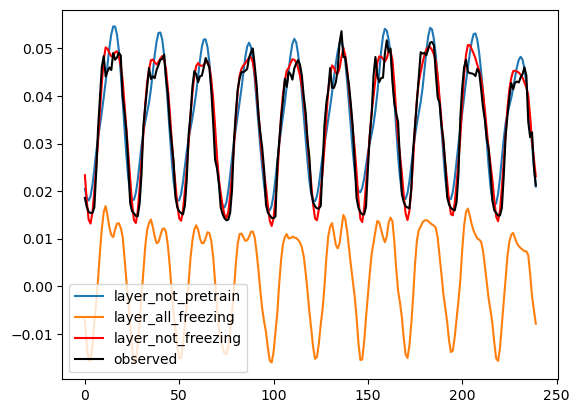

In [120]:
n =y_test.shape[0]
plt.plot(pred0[:n],label = 'layer_not_pretrain')
plt.plot(pred21[:n],label = 'layer_all_freezing')
plt.plot(pred22[:n],label = 'layer_not_freezing',color = 'red')
#plt.plot(pred31[:n],label = 'last_not_freezing')
#plt.plot(pred32[:n],label = 'last_not_freezing',color='brown')
plt.plot(y_test.flatten()[:n],label = 'observed',color = 'black')
plt.legend(loc='lower left')
plt.show()

`-` 평가지표

In [100]:
def MSE(y_pred, y_true):
    return np.mean((y_true - y_pred)**2)


def MAE(y_pred, y_true):
    absolute_errors = np.abs(y_true - y_pred)
    mae = np.mean(absolute_errors)
    return mae

def MAPE(y_true, y_pred):
    epsilon = 1e-10
    percentage_errors = np.abs((y_true - y_pred) / (y_true + epsilon)) * 100
    percentage_errors = np.nan_to_num(percentage_errors)
    mape = np.mean(percentage_errors)  
    return mape

In [102]:
y_observed= y_test.flatten()

lst1 = [total_training_time0,total_training_time21,total_training_time22]
lst2 =  [MSE(pred0.flatten(),y_observed), MSE(pred21.flatten(),y_observed), MSE(pred22.flatten(),y_observed)]
lst3 =  [MAE(pred0.flatten(),y_observed), MAE(pred21.flatten(),y_observed),MAE(pred22.flatten(),y_observed)]
lst4 =  [MAPE(pred0.flatten(),y_observed), MAPE(pred21.flatten(),y_observed),MAPE(pred22.flatten(),y_observed)]                                                                                                         
name = ['lstm_no_pretrain','lstm_use_freezing','lstm_not_freezing']
      #  'gru_no_pretrain','gru_use_freezing','gru_not_freezing']                                                                                                         

In [103]:
pd.options.display.float_format = '{:.7f}'.format
pd.DataFrame({'time(second)':lst1,
             'MSE':lst2,
              'MAE':lst3,
             'MAPE':lst4},index=name)

,time(second),MSE,MAE,MAPE
lstm_no_pretrain,4.8234618,0.0000196,0.0036641,11.6255815
lstm_use_freezing,5.9118953,0.0010151,0.0316519,700.5574370
lstm_not_freezing,6.9649339,0.0000063,0.0020283,6.6532814


`-` 결과

- freezing 하지 않는 pretrain model이 성능이 가장 좋게 나옴
- 걸리는 시간은 서로 엇비슷하다.
- target data의 크기에 따른 성능적 효율의 차이가 있을 것으로 예상
- freezing 모델은 유의하게 성능이 뒤떨어진다.